In [34]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from os.path import exists
import tensorflow as tf
import sklearn as skt

In [20]:
def download(ticker):

    data = yf.download(ticker, period="max")
    
    if data.empty:
        raise Exception(f"Ticker {ticker} is invalid")
    else:
        data.to_csv(ticker+".csv")

In [21]:
def normalize(data1):
    for key in data1.keys():
        if key == 'Date': continue
        stdev = np.std(data1[key])
        mean = np.average(data1[key])
        data1[key] = (data1[key] - mean) / stdev
    return data1

In [22]:
def interval_trim(data1, data2):
    #trimming the data to the same range
    min_date = max(data1['Date'].min(), data2['Date'].min())
    max_date = min(data1['Date'].max(), data2['Date'].max())

    data1 = data1[data1['Date'] >= min_date]
    data1 = data1[data1['Date'] <= max_date]
    data2 = data2[data2['Date'] >= min_date]
    data2 = data2[data2['Date'] <= max_date]

    data1 = data1.reset_index(drop=True)
    data2 = data2.reset_index(drop=True)
    
    #ensuring that the df have the same size
    if(data1['Date'].size > data2['Date'].size):
        data1 = data1.head(data2['Date'].size)
    if(data2['Date'].size > data1['Date'].size):
        data2 = data2.head(data1['Date'].size)

    return data1, data2

In [23]:
def print_correlation(ticker1, ticker2, k='Close', shift=0):
    
    ticker1 = ticker1.lower()
    ticker2 = ticker2.lower()
    print(ticker1, "------", ticker2)

    #creating filename from ticker
    filename1 = ticker1 + '.csv'
    filename2 = ticker2 + '.csv'

    #downloading the data if needed
    if not exists(filename1): download(ticker1)
    if not exists(filename2): download(ticker2)

    #reading data
    data1 = pd.read_csv(filename1)
    data2 = pd.read_csv(filename2)

    #adding a colum for the abs time
    # data1["ABS Time"] = time.mktime(dt.datetime(data1['Date'].str[0:4], data1['Date'].str[5:7], data1['Date'].str[8:10]))
    # data2["ABS Time"] = time.mktime(dt.datetime(data2['Date'].str[0:4], data2['Date'].str[5:7], data2['Date'].str[8:10]))

    #converting date to a date time object
    data1['Date'] = pd.to_datetime(data1['Date'])
    data2['Date'] = pd.to_datetime(data2['Date'])
    
    # creating comparable intervals
    data1, data2 = interval_trim(data1, data2)

    # adding shift
    # if shift > 0:
    #     data1 = data1.tail(data1['Date'].size - shift)
    #     data2 = data2.head(data2['Date'].size - shift)
    # elif shift < 0:
    #     data1 = data1.head(data1['Date'].size - shift)
    #     data2 = data2.head(data2['Date'].size - shift)


    #normalizing the data for comparability
    data1 = normalize(data1)
    data2 = normalize(data2)
    # printing the correlation of the data
    for key in data2.keys():
        if key == 'Date': continue
        cor = np.corrcoef(data1[key],data2[key])[0,1]
        print(key,':',cor)

    #adding in shift (shifts relative to data2)
    # if shift > 0:
    #     data1 = pd.concat([data1.head(shift), data1])
    #     data1 = data1.reset_index()
    #     data1 = data1.tail(data2['Date'].size - shift)
    # elif shift < 0:
    #     shift *= -1
    #     data2 = pd.concat([data2.head(shift), data2])
    #     data2 = data2.reset_index()
    #     data2 = data2.tail(data2['Date'].size - shift)
    

    #plotting the data on the same intervals, with shift if provided
    df_index = pd.DataFrame()
    df_index['index'] = range(1, len(data1) + 1)
    df_index['index'] = df_index['index'] + shift

    plt.plot(df_index['index'], data1[k])
    plt.plot(range(1, len(data2) + 1), data2[k])
    plt.show()
    print()
    


aapl ------ cl=f
Open : 0.16818596606997788
High : 0.1734641011726758
Low : 0.16256304078851838
Close : 0.1680073636662756
Adj Close : 0.15936060211319183
Volume : -0.3158721134995847


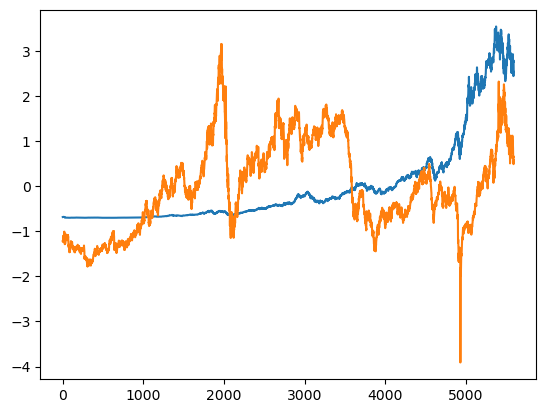

In [24]:
print_correlation('aapl', 'cl=f')

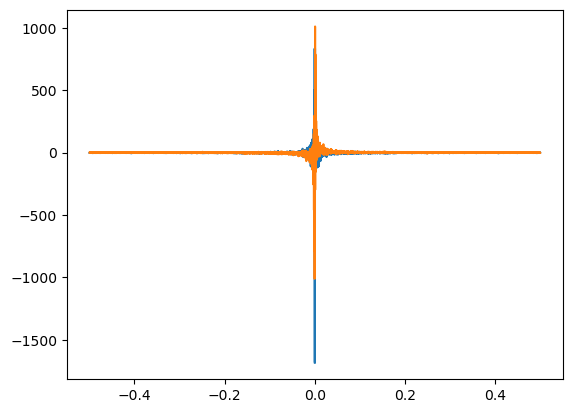

In [9]:
clf = pd.read_csv('cl=f.csv')
clf = normalize(clf)
sp =np.fft.fft(np.sin(clf['Open']))
freq = np.fft.fftfreq(clf['Open'].size)
plt.plot(freq, sp.real, freq, sp.imag)

/var/folders/kb/0l4w38hx08g7nd33fqj3k96c0000gn/T/ipykernel_43113/2928570142.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(np.asarray(fft, float))


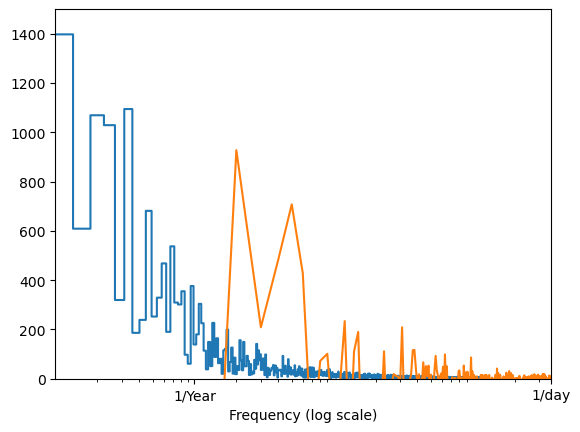

In [25]:
data = clf["Close"]
#data = np.sin(np.arange(1,900) / (2 * np.pi))

fft = tf.signal.rfft(data)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(data)
hours_per_year = 24*365.2524
years_per_dataset = 22.34

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.yscale('log')
plt.ylim(0, 1500)
plt.xlim([0.1, max(plt.xlim())])
plt.plot(np.asarray(fft, float))
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
tf.keras.test_train_split()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [27]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target)
clf = LinearRegression()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
expected = y_test

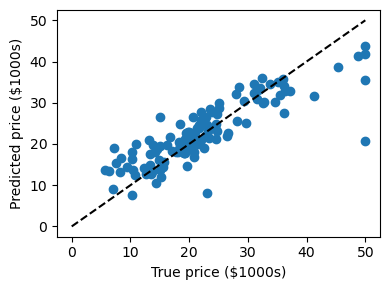

In [28]:
plt.figure(figsize=(4, 3))
plt.scatter(expected, predicted)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)')
plt.tight_layout()

In [32]:
skt.ARIMA()

AttributeError: module 'sktime' has no attribute 'ARIMA'

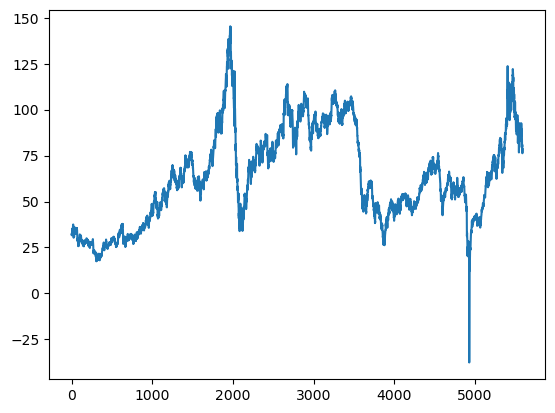

In [36]:
oil = pd.read_csv('cl=f.csv')['Adj Close']
plt.plot(oil)